## 모듈 import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [4]:
!git clone https://github.com/kwansu/RL-env-grid.git

Cloning into 'RL-env-grid'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 163 (delta 88), reused 112 (delta 44), pack-reused 0
Receiving objects: 100% (163/163), 156.66 KiB | 6.03 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [5]:
cd RL-env-grid/

/content/drive/MyDrive/RL-env-grid


In [6]:
!pip install pygame

import cv2
import time
import os, sys
import numpy as np

from glob import glob
from google.colab.patches import cv2_imshow
from google.colab import output

sys.path.append('/content/drive/MyDrive/RL-env-grid')
os.environ["SDL_VIDEODRIVER"] = "dummy"

     |████████████████████████████████| 21.8 MB 1.3 MB/s 


In [7]:
from state import *
from environment.grid_world import GridWorld

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 환경 생성

In [8]:
def show(x):
    img_bgr = x.get_image()
    cv2_imshow(img_bgr)

/content/drive/MyDrive/RL-env-grid/environment/sprite/*.png
{'down': '/content/drive/MyDrive/RL-env-grid/environment/sprite/down.png', 'goal': '/content/drive/MyDrive/RL-env-grid/environment/sprite/goal.png', 'left': '/content/drive/MyDrive/RL-env-grid/environment/sprite/left.png', 'left_item': '/content/drive/MyDrive/RL-env-grid/environment/sprite/left_item.png', 'player': '/content/drive/MyDrive/RL-env-grid/environment/sprite/player.png', 'pusher': '/content/drive/MyDrive/RL-env-grid/environment/sprite/pusher.png', 'right': '/content/drive/MyDrive/RL-env-grid/environment/sprite/right.png', 'right_item': '/content/drive/MyDrive/RL-env-grid/environment/sprite/right_item.png', 'trap': '/content/drive/MyDrive/RL-env-grid/environment/sprite/trap.png', 'up': '/content/drive/MyDrive/RL-env-grid/environment/sprite/up.png'}
12 5


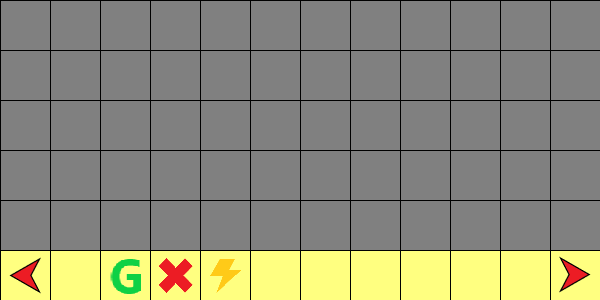

In [9]:
state_size = (12, 5)
items = (State, Goal, Trap, Pusher)

env = GridWorld(*state_size, items=items, is_render=False, state_length=50)
show(env)


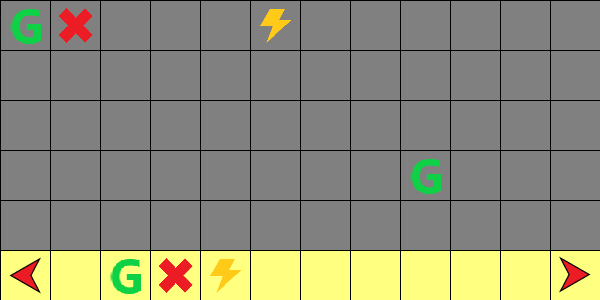

In [10]:
env.change_state((0, 0), Goal)
env.change_state((1, 0), Trap)
env.change_state((5, 0), Pusher)
env.change_state((8, 3), Goal)
show(env)

## dynamic programming

In [11]:
actions = ("up", "down", "left", "right")
action_size = len(actions)
gamma = 0.9


def reset(state_size, action_size):
    values = np.zeros(state_size)
    # uniform policy
    policy = np.ones((*state_size, action_size)) * (1 / action_size)
    return values, policy


values, policy = reset(state_size, action_size)

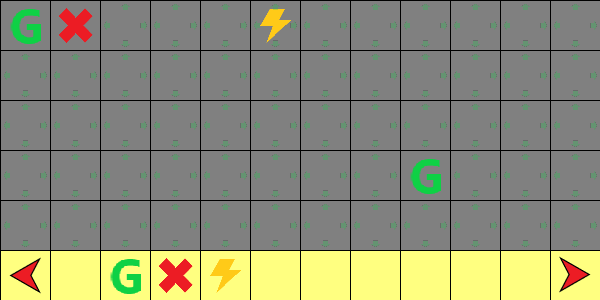

In [12]:
env.draw_policy(policy)
show(env)

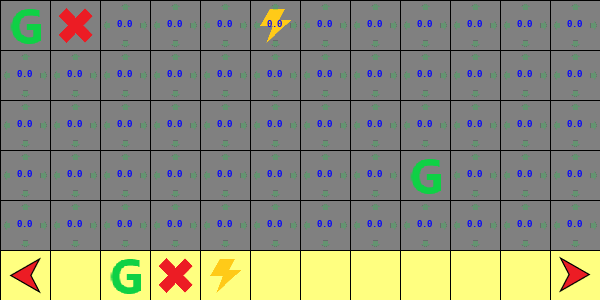

In [13]:
env.draw_values(values)
show(env)

### policy iteration

In [14]:
def update_bellman_equation(values, states):
    assert values.shape == states.shape

    copy = values.copy()
    row, col = values.shape
    for x in range(row):
        for y in range(col):
            if states[x, y].is_terminal:
                continue
                
            new_v = 0
            for action, pi_p in zip(actions, policy[x, y]):
                for pos, p in states[x, y].get_action_trans_prob(action).items():
                    new_v += pi_p * p * (states[pos].reward + gamma * copy[pos])

            values[x, y] = new_v

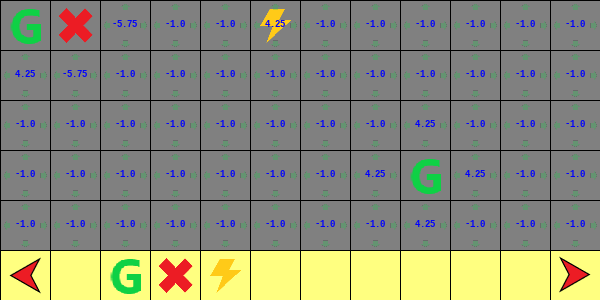

In [15]:
update_bellman_equation(values, env.states)

env.draw_values(values)
show(env)

In [16]:
def policy_evaluation(values, env, k=1):
    for _ in range(k):
        update_bellman_equation(values, env.states)

    env.draw_values(values)
    show(env)

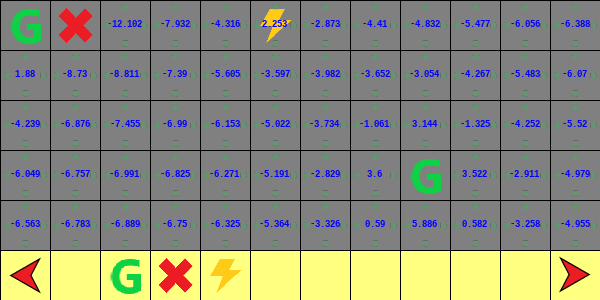

In [17]:
policy_evaluation(values, env, 10)

In [18]:
def policy_imporvement(values, policy, env, gamma):
    states = env.states
    assert values.shape == states.shape

    row, col = values.shape
    for x in range(row):
        for y in range(col):
            max_q = float("-inf")
            for i, action in enumerate(actions):
                q = 0
                for pos, p in states[x, y].get_action_trans_prob(action).items():
                    q += p * (states[pos].reward + gamma * values[pos])
                # q = sum(
                #     [
                #         p * (states[pos].reward + gamma * states[pos])
                #         for pos, p in states[x, y].get__action_trans_prob(action)
                #     ]
                # )
                if q > max_q:
                    max_q, max_count = q, 1
                    policy[x, y, :] = 0
                    policy[x, y, i] = 1
                elif q == max_q:
                    max_count += 1
                    policy[x, y, i] = 1
            policy[x, y] /= max_count

    env.draw_policy(policy)
    show(env)

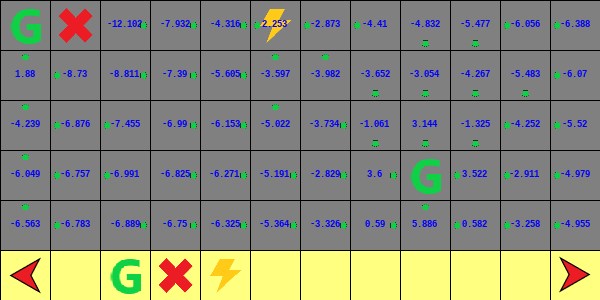

In [19]:
policy_imporvement(values, policy, env, gamma)

In [20]:
def policy_iteration(values, policy, env, k=1, num_iteration=1, gamma=0.9):
    policy_evaluation(values, env, k)
    policy_imporvement(values, policy, env, gamma)

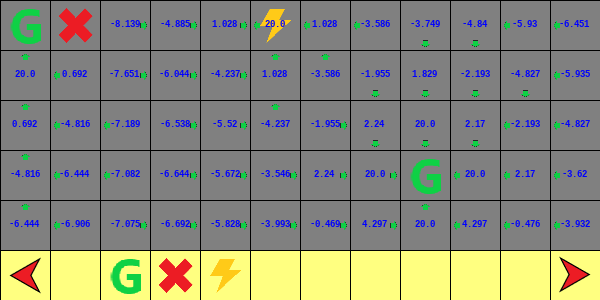

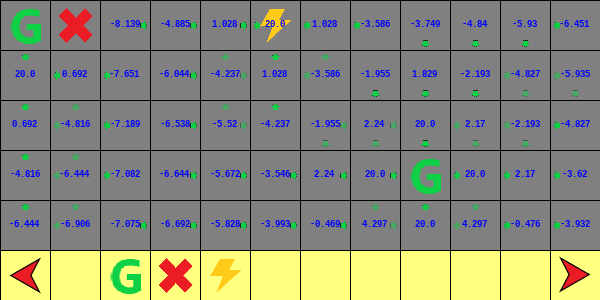

In [21]:
policy_iteration(values, policy, env)

## 해볼 만한 것들

### 환경 추가 및 테스트
- 좀 더 다양한 state 기능들을 추가해서 사람도 한번에 최적의 이동경로를 찾기 힘든 환경을 만들어서 실험해보자.
- 에이전트를 추가해서 optimal policy를 따라 최적을 경로를 따라가도록 만들어보자.(greedy)

<br/>

### policy iteration
- 앞에 구현에서 evaluation을 bellman expectation equation을 반복적으로 사용한다.
- 완전 기본 policy iteration에서는 evaluation을 수렴할 때 까지 반복한다.
- 이 부분을 만족하는 policy iteration 기능을 만들어보자.
- 추가적으로 state-transition probability를 알고 있으므로, evaluation을 반복적인 계산이 아닌 행렬 계산을 이용해서 구해보자.

<br/>

### value iteration
- 이것도 구현해보자

<br/>

### ohter

- iteration에서 할 때, 계속 values가 변하기 때문에 value copy본을 만들어서 사용한다. 이걸 없이 할 경우 어떻게 될지 실험해보자.
- 한번에 모든 state가 아닌 지역적인 state으로 업데이트 시키면서 control을 풀어보자.